In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy

In [32]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print('Using {} device'.format(device))
#device = torch.device("cpu")

Using mps device


In [33]:
X_test = np.load("X_test.npy")
# X_test = scipy.stats.zscore(X_test, axis=1)
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
# X_train_valid = scipy.stats.zscore(X_train_valid, axis=1)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_test -= 769
y_train_valid -= 769

In [34]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# Data preprocessing by TA's approach

In [35]:
def data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))    
    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

In [36]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting


#Subject1
train_valid_1_idx = list(np.where(person_train_valid==1)[0])
X_train_valid_1 = X_train_valid[train_valid_1_idx]
y_train_valid_1 = y_train_valid[train_valid_1_idx]
test_1_idx = list(np.where(person_test==1)[0])
X_test = X_test[test_1_idx]
y_test = y_test[test_1_idx]


idx_val = np.random.choice(236, 47, replace=False)
idx_tra = np.array(list(set(range(236)).difference(set(idx_val))))
X_train, X_val = X_train_valid_1[idx_tra], X_train_valid_1[idx_val] 
y_train, y_val = y_train_valid_1[idx_tra], y_train_valid_1[idx_val]

## Preprocessing the dataset
X_train,y_train = data_prep(X_train,y_train,2,2,True)
X_val,y_val = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training set: (756, 22, 250)
Shape of validation set: (375, 22, 1000)
Shape of training labels: (756,)
Shape of validation labels: (375,)


# To torch.tensor

In [37]:
X_train = torch.from_numpy(X_train).float()
X_train = X_train[:,None,:,:]
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
X_val = X_val[:,None,:,:]
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test_prep).float()
X_test = X_test[:,None,:,:]
y_test = torch.from_numpy(y_test_prep).long()

# Dataset Class

In [38]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Network

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Conv2d(in_channels, out_channels, kernel_size)
        #input:(C,H,W)=(1,22,1000)
        
        self.conv1 = nn.Conv2d(1, 32, (1,64), padding='same') #(32,22,250)
        self.bn1   = nn.BatchNorm2d(32) #(32,22,250)
        
        self.conv2 = nn.Conv2d(32, 64, (22,1)) #(64,1,250)
        self.bn2   = nn.BatchNorm2d(64) #(64,1,250) 
        #--->ELU()
        self.pool1 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0) #(64,1,50)
        
        self.conv3 = nn.Conv2d(64, 64, (1,16), padding='same') #(64,1,50)
        self.conv4 = nn.Conv2d(64, 64, (1,1), padding='same') #(64,1,50)
        self.bn3   = nn.BatchNorm2d(64) #(64,1,50)
        #--->ELU()
        self.pool2 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0) #(64,1,10)
        
        self.fc1 = nn.Linear(64*1*10,256)
        self.fc2 = nn.Linear(256,4)
        
        self.sm = nn.Softmax(dim=1)
        
        #non-linear
        self.nonlinear = nn.ELU(True)
        #Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.bn1(self.conv1(x))
        
        x = self.nonlinear(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout(x)
        
        x = self.nonlinear(self.bn3(self.conv4(self.conv3(x))))
        x = self.pool2(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.sm(x)
        return x

In [41]:
def train_epoch(model, optimizer, criterion, dataloader):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (inp, labels) in enumerate(dataloader):
        inp, labels = inp.to(device), labels.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        outp_pred = torch.max(outp,axis=1).indices
        train_acc += torch.sum(outp_pred == labels)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc/ len(train_dataloader.dataset)
    return train_loss, train_acc

In [42]:
def predict(model, optimizer, criterion, dataloader, pred_loader=test_dataloader):
    test_loss = 0
    test_acc = 0
    best_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, labels) in enumerate(pred_loader):
            inp, labels = inp.to(device), labels.to(device)
            outp = model(inp)
            outp_pred = torch.max(outp,axis=1).indices
            test_acc += torch.sum(outp_pred == labels)
            loss = criterion(outp, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(pred_loader.dataset)
        test_acc = test_acc / len(pred_loader.dataset)
    return test_loss, test_acc

In [43]:
acc_device = torch.device('cpu')
def run(num_epochs, optimizer, criterion, pred_loader=test_dataloader):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    best_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_dataloader)
        test_loss, test_acc = predict(model, optimizer, criterion, pred_loader)
        # if epoch % 5 == 0:
        #     print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
        #         train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
                train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc.to(acc_device))
        test_acc_list.append(test_acc.to(acc_device))

        if test_acc > best_acc and pred_loader != test_dataloader:
            torch.save(model.state_dict(), 'CNN_model_subject1_dataTA.pt')
            best_acc = test_acc
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [44]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [46]:
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(200, optimizer, criterion, val_dataloader)

Epoch [1], train_Loss : 0.0219, val_Loss : 0.0448,                train_accuracy : 71.5608%, val_accuracy : 46.0000%
Epoch [2], train_Loss : 0.0163, val_Loss : 0.0607,                train_accuracy : 79.8942%, val_accuracy : 45.5000%
Epoch [3], train_Loss : 0.0190, val_Loss : 0.0591,                train_accuracy : 76.4550%, val_accuracy : 40.5000%
Epoch [4], train_Loss : 0.0167, val_Loss : 0.0578,                train_accuracy : 78.0423%, val_accuracy : 44.5000%
Epoch [5], train_Loss : 0.0143, val_Loss : 0.0538,                train_accuracy : 82.0106%, val_accuracy : 54.0000%
Epoch [6], train_Loss : 0.0113, val_Loss : 0.0581,                train_accuracy : 86.6402%, val_accuracy : 48.5000%
Epoch [7], train_Loss : 0.0088, val_Loss : 0.0660,                train_accuracy : 89.8148%, val_accuracy : 40.5000%
Epoch [8], train_Loss : 0.0079, val_Loss : 0.0597,                train_accuracy : 90.4762%, val_accuracy : 50.0000%
Epoch [9], train_Loss : 0.0109, val_Loss : 0.0646,              

In [47]:
model = CNN().to(device)
model.load_state_dict(torch.load('CNN_model_subject1_dataTA.pt'))
model.eval()
test_loss, test_acc = predict(model, optimizer, criterion, test_dataloader)

print(f'Test_Loss : {test_loss:.4f},Test_Accuracy : {100*test_acc:.4f}%')

Test_Loss : 0.1092,Test_Accuracy : 68.5000%


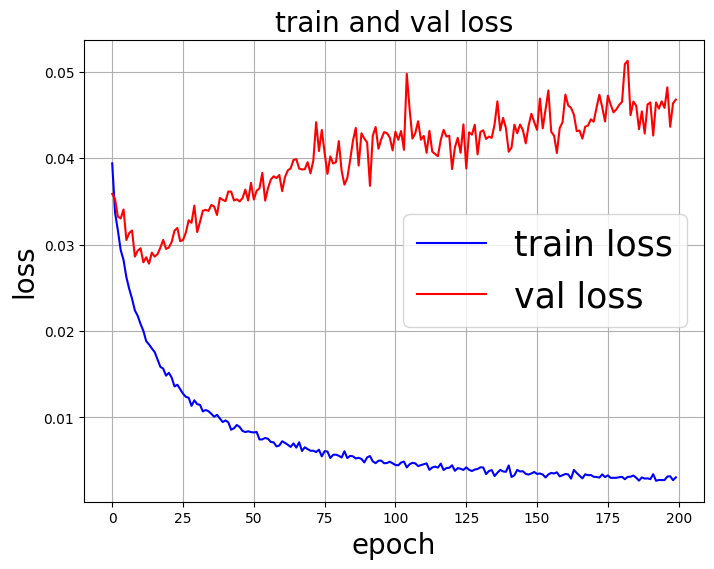

In [17]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='val loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

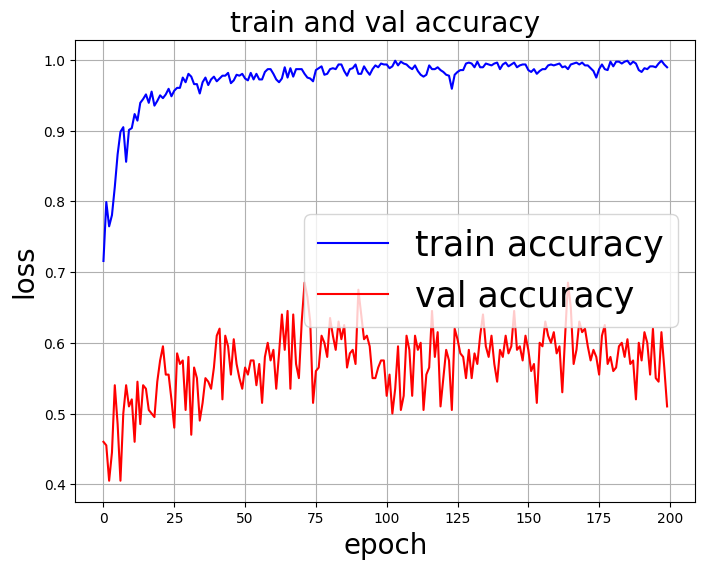

In [48]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_acc_list, c='b', label='train accuracy')
ax.plot(range(num_epochs), test_acc_list, c='r', label='val accuracy')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val accuracy', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

In [49]:
from torchsummary import summary
model = CNN()
summary(model, (1, 22, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 22, 250]           2,080
       BatchNorm2d-2          [-1, 32, 22, 250]              64
            Conv2d-3           [-1, 64, 1, 250]          45,120
       BatchNorm2d-4           [-1, 64, 1, 250]             128
               ELU-5           [-1, 64, 1, 250]               0
         AvgPool2d-6            [-1, 64, 1, 50]               0
           Dropout-7            [-1, 64, 1, 50]               0
            Conv2d-8            [-1, 64, 1, 50]          65,600
            Conv2d-9            [-1, 64, 1, 50]           4,160
      BatchNorm2d-10            [-1, 64, 1, 50]             128
              ELU-11            [-1, 64, 1, 50]               0
        AvgPool2d-12            [-1, 64, 1, 10]               0
          Dropout-13            [-1, 64, 1, 10]               0
           Linear-14                  [